# MLiM 25440 Homework 3 : Programming Assignment
### Brendan Sanderson

#### Imports and Mounting Drive

In [0]:
#General Useful Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time
from sklearn.metrics import mean_absolute_error
import math
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#Regression Models Imports
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

#Classifier Models Imports



#Deep Learning Model Imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#### Helper functions

In [0]:
# Timer helper class for timing methods.
class Timer(object):
    """Timer class
       Wrap a will with a timing function
    """
    
    def __init__(self, elapsed):
        self.elapsed = elapsed
        
    def __enter__(self):
        self.t = time.time()
        
    def __exit__(self, *args, **kwargs):
        tim =  time.time() - self.t
        self.elapsed.append(tim)
        
        

## Part 1. “By Drug” Tumor Response (50 points).

#### Loading and Preprocessing the data

I have chosen drugs 2, 29, 33, 51, 136, 196, 220, 246, 447 and 470. I chose these because they all have a large amount of columns and also have 309 tumors in common.

In [0]:
#Loads in all the data and removes the aucs into a seperate array.
drug_numbers = ['2','29','33','51','136','196', '220', '346','447', '470']
#drug_data contains all the actual data
drug_data = []
#drug_names is a list of the drug names
drug_names = []
#drug_tumors is a list of all tumors recorded for each drug
drug_tumors = []
#drug_auc is the y value which is all of the aucs recorded for each tumor and each drug
drug_auc = []
print('\r', "Drug Datasets Loaded:", 0, "out of 10", end='')
for i,dn in enumerate(drug_numbers):
  dd = pd.read_csv(
      "/content/drive/My Drive/MLiM-Datasets/HW3/data_frames/Part1/df_drug.CTRP." + dn + ".tsv",
      delimiter='\t')
  drug_names.append(dd.pop("DRUG")[0])
  drug_tumors.append(set(dd["CELL"]))
  dd = dd.set_index('CELL')
  drug_auc.append(dd.pop("AUC1"))
  drug_data.append(dd)
  print('\r', "Datasets Loaded:", i+1, "out of 10", end='')
  
  

 Datasets Loaded: 10 out of 10

In [0]:
#Normalizes the data
def normalize_large_data(df):
  scaler = preprocessing.StandardScaler()
  columns = df.columns
  scaled_df = scaler.fit_transform(df)
  df = pd.DataFrame(scaled_df, columns=columns)
  return df

for df in drug_data:
  df = normalize_large_data(df)

#### Helper Functions

I will define 3 functions. get_common_tumors gets all tumors common between the drugs:
*   get_common_tumors gets all tumors common between the drugs.
*   five_fold_holdout calculates the holdout set, then divides it into 5 seperate sets for 5-fold testing. For each fold it removes the tumors in the testing from the dataset for each drug in order to create the corresponding training set.
*   remove_holdout removes the holdout set from all of the dataframes for each drug.



In [0]:
#Function to get the common tumors given the tumors in each drug
def get_common_tumors(dtumors):
  ct = dtumors[0]
  for d in dtumors[1:]:
    ct = ct.intersection(d)
  return list(ct)

#Function to perform 5-fold where the testing data is exclusive to the common tumors
def five_fold_holdout(dtumors, ddata):
  #Determine the tumors in common
  common_tumors = get_common_tumors(dtumors)
  
  # Divide the common tumors into subsets
  testing_sets = list(np.split(np.array(common_tumors)[:305],indices_or_sections=5))
  testing_sets[0]=np.append(testing_sets[0],common_tumors[305])
  testing_sets[1]=np.append(testing_sets[1],common_tumors[306])
  testing_sets[2]=np.append(testing_sets[2],common_tumors[307])
  testing_sets[3]=np.append(testing_sets[3],common_tumors[308])

  # Get the 5 training sets for each drug given the 5 testing holdout sets.
  training_sets = []
  for dd in ddata:
    drug_training_sets = []
    for t in testing_sets:
      drug_training_sets.append(np.setdiff1d(dd.index,t))
    training_sets.append(drug_training_sets)
  return training_sets, testing_sets


def remove_holdout(dtumors, ddata):
  common_tumors = get_common_tumors(dtumors)
  ddata = ddata.copy()
  for i in range(len(ddata)):
    ddata[i] = ddata[i].drop(common_tumors)
  return ddata

### a) Using SciKit Learn build a machine learning regressor that predicts the AUC response for tumors for each of 10 drugs selected by you from the 250 drugs available. Sweep through multiple ML methods. Report on which drugs were best for which tumors and which ML methods performed the best.

I am going to break this problem down in to 2 parts. First, I will determine the best model for each drug. Then, I will use the best model for each drug in order to determine which drugs were best for which tumors.

#### i) Determining the best model for each drug.

I am going to train 5 regression models on each of the 10 drug datasets using 5-fold validation. I will run it on all data excluding the holdout set. Afterwards, I will print the MAE for each model as well as the runtime. I will select the best model for each drug and use that model to determine how well each drug worked on each tumor. The 5 regression models I am testing are SGD, SVR, Guassian Process, Bayesian Ridge and Decision Tree.

In [0]:
#Function to run 5-fold validation on a given model, X and y. It returns the average runtime and the average MAE
def five_fold_predict(model, name, X, Y, p = False):
  errs = []
  tim = []
  kf = KFold(n_splits=5)
  if p:
    print("Running 5 fold with", name)
  for train_index, test_index in kf.split(X):
      X_train, X_test = X.values[train_index], X.values[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
      with Timer(tim):
        model.fit(X_train, y_train)
      y_hat = model.predict(X_test)
      errs.append(mean_absolute_error(y_hat,y_test))
  if p:
    print("Finished Running...", "Mean Absolute error:",np.mean(errs), "Average Training Time",np.mean(tim))
  return (np.mean(errs),np.mean(tim))


#Function to cleanly print the results from the prior function
def print_all_models_results(ds_name,names, results):
  print("----------------------------------------------------")
  print("Results for", ds_name)
  print("")
  print("Best MAE:", sorted(zip(np.array(results).T[0], names))[0][1])
  print("Best Training Time:", sorted(zip(np.array(results).T[1], names))[0][1])
  print("")
  for n,r in zip(names,results):
    print(n,":", "Mean Absolute error:",r[0], "Average Training Time",r[1])
  print("----------------------------------------------------")
  print("")
  
  

In [0]:
#Define the regressors that I will use
regressors = [
  SGDRegressor(penalty="l2"),
  SVR(gamma = 'auto'),
  GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0),
  BayesianRidge(),
  DecisionTreeRegressor()
  ]

#Define the naems of the regressors that I will use
names = [
    "SGD Regression",
    "Support Vector Regression",
    "Guassian Process Regression",
    "Bayesian Ridge Regression",
    "Decision Tree Regression"
]

#Remove the holdout as we don't want to include the holdout in model selection.
drug_data_no_holdout = remove_holdout(drug_tumors, drug_data)


#Run the regressors on all 10 drugs using 5-fold.
all_results = []
for i,(X,y) in enumerate(zip(drug_data_no_holdout, drug_auc)):
  results = []
  for j, (r, n) in enumerate(zip(regressors, names)):
    print('\r', "Drugs Completed:", i, "out of 10", " Models Completed For Current Drug:",j+1,"out of 5", end='')
    results.append(five_fold_predict(r,n, X, y))
  print('\r', "Drugs Completed:", i+1, "out of 10", end='')
  all_results.append(results)
print("")

#Calculate and print the mean results for each regressor
mean_results = list(zip([ np.mean(m) for m in np.array(all_results).T[0]],[ np.mean(t) for t in np.array(all_results).T[1]]))
print_all_models_results("Overall", names,  mean_results)

#Print the results
for n,r in zip(drug_names, all_results):
  print_all_models_results(n, names, r)
  
#Calculate the best model for each drug
drug_models = [sorted(zip(np.array(results).T[0], regressors))[0][1] for results in all_results]

 Drugs Completed: 10 out of 10
----------------------------------------------------
Results for Overall

Best MAE: Bayesian Ridge Regression
Best Training Time: SGD Regression

SGD Regression : Mean Absolute error: 1091.176332715489 Average Training Time 0.20162256717681887
Support Vector Regression : Mean Absolute error: 0.10903259857833233 Average Training Time 0.2202882194519043
Guassian Process Regression : Mean Absolute error: 0.16611830532654132 Average Training Time 1.2425053310394287
Bayesian Ridge Regression : Mean Absolute error: 0.10293832419023137 Average Training Time 0.892210283279419
Decision Tree Regression : Mean Absolute error: 0.13995044931999742 Average Training Time 0.40550752639770515
----------------------------------------------------

----------------------------------------------------
Results for CTRP.2

Best MAE: Bayesian Ridge Regression
Best Training Time: SGD Regression

SGD Regression : Mean Absolute error: 2981.533530769623 Average Training Time 0.04938

In every single case, the Bayesian Ridge Regression performed the best. These results are somewhat surprising to me as SVC performed the best on the previous homework. However, once I read into how Bayesian works, it does make some sense. SGD Regression performed terribly, which was surprising as I have always thought of SGD as a consistent model. However, perhaps it is only really useful when applied to networks as an optimization method.

In terms of runtime, they all were fairly quick, but the datasets were not too large, so this is expected. The Bayesian took the longest, which makes sense given that it was the best.

I will use the Bayesian Regression for all drugs going forward.

#### ii) Now that I have determined the best model for each drug. I will determine what drug works best on what tumor.

In this section, I first find all tumors in common between all of the drugs. I divide this set into 5 different sets. I use these 5 tests as my 5 testing sets. For each testing set, I then compute the training set which is all tumors for each drug except the tumors in that specific testing set. This is all done using the helper function defined above.

Once I have my 5 testing sets and 5 training sets for each drug. I train the model and estimate the drug response for each tumor in each testing set. I do this and calculate the estimated drug response for each tumor for each drug.

In [0]:
# Parameters: a model, drug name, X data, y data, 5 sets of indice names for training and 5 sets of indice names for testing
# Taking in the parameters, this function trains the model with each set of training indices and tests the model with each set of testing indices
# It returns the average error, runtime and the predicted value for each tumor in the test indices

def five_sets_predict_tumors(model, name, X, y, train_inds, test_inds, p=False):
  errs = []
  tim = []
  estimated_tumors = {}
  if p:
    print("Running 5 fits and predicts with", name)
  for train_ind, test_ind in zip(train_inds, test_inds):
    X_train, y_train = X.loc[train_ind], y.loc[train_ind]
    X_test, y_test = X.loc[test_ind], y.loc[test_ind]
    for ti in train_ind:
      if ti not in X.index:
        print(ti)
    with Timer(tim):
      model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    errs.append(mean_absolute_error(y_hat,y_test))
    for k,v in zip(test_ind, y_hat):
      estimated_tumors[k] = v
  if p:
    print("Finished Running...", "Mean Absolute error:",np.mean(errs), "Average Training Time",np.mean(tim))
  return (sum(errs),np.mean(tim), estimated_tumors)

In [0]:
#Predict the common tumors for all drugs.
tumor_predictions = []
maes = []
times = []

best_model = BayesianRidge()

training_sets, testing_sets = five_fold_holdout(drug_tumors, drug_data)
for i, dname, ddata, dauc, training_set in list(zip(range(10), drug_names, drug_data, drug_auc, training_sets)):
  res = five_sets_predict_tumors(best_model, dname, ddata, dauc, training_set, testing_sets)
  print('\r', "Tumors estimated for Drugs:", i+1, "out of 10", end='')
  tumor_predictions.append(res[2])
  maes.append(res[0])
  times.append(res[1])
  

 Tumors estimated for Drugs: 10 out of 10

Now that I have estimated the effect of every drug on all common tumors. I will now determine which drug is estimated to work best on each tumor based on my models. I will print the MAE, the runtime, the tumors that each drug was best for and how many drugs each tumor was best for.

In [0]:
common_tumors = get_common_tumors(drug_tumors)
#Determine what drug performed best on each tumor based on the previous data
tumor_matrix = [[tp[tum] for tp in tumor_predictions] for tum in common_tumors]
tumor_estimated_df = pd.DataFrame(tumor_matrix, index=common_tumors, columns = drug_names)

best_drugs = [ min(list(zip(tumor_estimated_df.loc[tum].tolist(),tumor_estimated_df.loc[tum].index)))[1] for tum in common_tumors]

best_tumors = {}
for i in drug_names:
  best_tumors[i] = []
for n, bd in zip(common_tumors, best_drugs):
  best_tumors[bd].append(n)

In [0]:
#Print the results
def print_all_models_results(ds_name, best_tumors, mae, tim):
  print("----------------------------------------------------")
  print("Results for", ds_name)
  print("")
  print("Total MAE:", mae)
  print("Average Training Time:", tim)
  print("")
  print("Drug is best for", len(best_tumors), "tumors")
  print("Tumors this drug is best for")
  print(best_tumors)
  print("----------------------------------------------------")
  print("")
  
  
for name, mae, tim in zip(drug_names, maes, times):
  print_all_models_results(name, best_tumors[name], mae, tim)

----------------------------------------------------
Results for CTRP.2

Total MAE: 0.5305078276310309
Average Training Time: 1.9054037570953368

Drug is best for 0 tumors
Tumors this drug is best for
[]
----------------------------------------------------

----------------------------------------------------
Results for CTRP.29

Total MAE: 0.34402850584768546
Average Training Time: 2.920570230484009

Drug is best for 43 tumors
Tumors this drug is best for
['df_agg_ctrp.tsv:CTRP.PC-3', 'df_agg_ctrp.tsv:CTRP.SK-MES-1', 'df_agg_ctrp.tsv:CTRP.PA-TU-8988S', 'df_agg_ctrp.tsv:CTRP.KMRC-2', 'df_agg_ctrp.tsv:CTRP.ZR-75-30', 'df_agg_ctrp.tsv:CTRP.BC-3C', 'df_agg_ctrp.tsv:CTRP.HCC1500', 'df_agg_ctrp.tsv:CTRP.C2BBe1', 'df_agg_ctrp.tsv:CTRP.EFO-21', 'df_agg_ctrp.tsv:CTRP.Panc-04-03', 'df_agg_ctrp.tsv:CTRP.BT147', 'df_agg_ctrp.tsv:CTRP.MDA-MB-453', 'df_agg_ctrp.tsv:CTRP.NCI-H1944', 'df_agg_ctrp.tsv:CTRP.HOP-92', 'df_agg_ctrp.tsv:CTRP.NCI-H1651', 'df_agg_ctrp.tsv:CTRP.Hs-888-T', 'df_agg_ctrp.tsv:CTR

Based off our models, we estimate how effectively each drug is on each common tumor and then find which drug did the best (lowest AUC). Interestingly, one drug (CTRP.220) performed best for 78% of the drugs and 7 drugs performed best for 0 or very few tumors (5 or less). The other two drugs performed best for 43 and 17 tumors respectively. This makes it clear that I picked 1 drug that is extremely effective against a lot of different tumors, 2 drugs that effective against some tumors and the rest of the drugs are not very useful at all.

### b) Using feature selection methods of your choice determine a < 100 gene signature that can be used to classify Normal vs Tumor.

To reduce features, I iterateively run the Decision Tree Regressor and remove the worst 10% of important features until there are less than 100 features. I chose to use the Decision Tree Regressor as it ranks the importance of all of the features nicely, making it easy to deterine which features are better than others.

In [0]:

errors = []
times = []

model = DecisionTreeRegressor()


drugs_little_features_data = drug_data.copy()

for i, da in zip(range(10), drug_auc):
  dd = drugs_little_features_data[i]
  while len(dd.columns) > 100:
    #fit the data and get the feature rankings
    model.fit(dd, da)
    feature_rankings = model.feature_importances_
    #sort the features
    sorted_test = sorted(list(enumerate(feature_rankings)),key= lambda x: x[1])
    #remove the features
    dd = dd.drop(columns=[dd.columns[x[0]] for x in sorted_test[:int(len(sorted_test)*0.1)]])
    print('\r', "Drugs Done:",i,"of 10  ",len(dd.columns),"Features left on current drug.", end='')
  drugs_little_features_data[i] = dd
  print('\r', "Drugs Done:",i+1,"of 10.", end='')


 Drugs Done: 10 of 10.

Now that I reduced all of the drugs to less than 100 features, I willran the Bayesian Ridge Regression on both the original data and the data with reduced features in order to compare them.

In [0]:
best_model = BayesianRidge()

results = []
all_results = []
for i,(Xf, Xa,y, model) in enumerate(zip(drugs_little_features_data, drug_data, drug_auc, drug_models)):
  #Run it on the data with reduced features
  results.append(five_fold_predict(model,"Bayesian Ridge", Xf, y))
  #Run it on the data with all features
  all_results.append(five_fold_predict(model,"Bayesian Ridge", Xa, y))
  print('\r', "Drugs Completed:", i+1, "out of 10", end='')
print("")


 Drugs Completed: 10 out of 10


In [0]:
#print the results
for r,n,b in zip(results, drug_names,all_results):
  print("----------------------------------------------------")
  print("Results for", n)
  print("Total MAE Reduced Features:", r[0], "Total MAE All Features:",b[0])
  print("Average Training Time:", r[1])
print("----------------------------------------------------")

----------------------------------------------------
Results for CTRP.2
Total MAE Reduced Features: 0.10244581134940238 Total MAE All Features: 0.10042349463793436
Average Training Time: 0.03191213607788086
----------------------------------------------------
Results for CTRP.29
Total MAE Reduced Features: 0.10782907583073269 Total MAE All Features: 0.08233774525010652
Average Training Time: 0.029114151000976564
----------------------------------------------------
Results for CTRP.33
Total MAE Reduced Features: 0.08827702027663734 Total MAE All Features: 0.0697852191175195
Average Training Time: 0.016052103042602538
----------------------------------------------------
Results for CTRP.51
Total MAE Reduced Features: 0.06865622083844139 Total MAE All Features: 0.06734844480534734
Average Training Time: 0.01527719497680664
----------------------------------------------------
Results for CTRP.136
Total MAE Reduced Features: 0.04469380924772679 Total MAE All Features: 0.044455048625339236
A

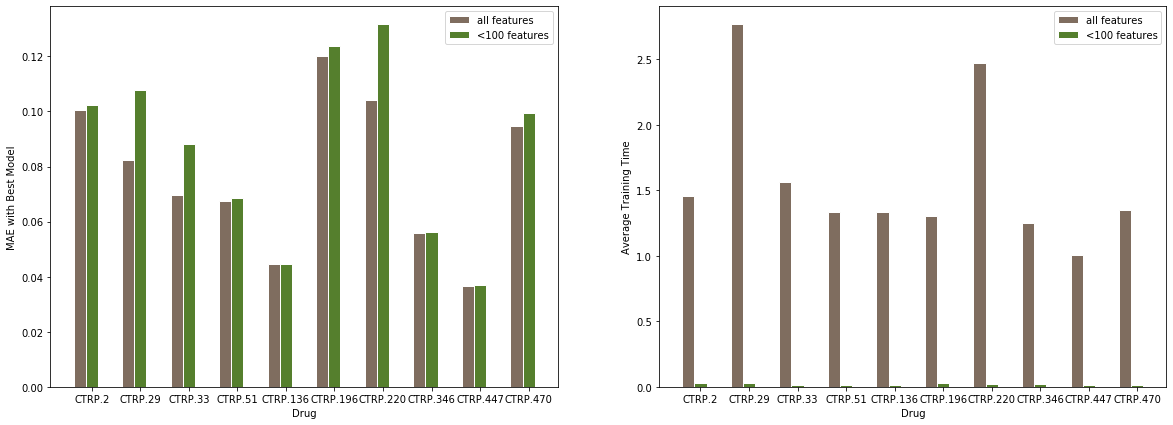

In [0]:
reduced_maes = [r[0] for r in results]
all_maes = [r[0] for r in all_results]
barWidth = 0.25
r1 = np.arange(len(reduced_maes))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.bar(r1, all_maes, color='#7f6d5f', width=barWidth, edgecolor='white', label='all features')
plt.bar(r2, reduced_maes, color='#557f2d', width=barWidth, edgecolor='white', label='<100 features')

plt.xlabel('Drug')
plt.ylabel('MAE with Best Model')
plt.xticks([r + barWidth for r in range(len(reduced_maes))], drug_names)
plt.legend()


reduced_times = [r[1] for r in results]
all_times = [r[1] for r in all_results]

plt.subplot(1,2,2)
plt.bar(r1, all_times, color='#7f6d5f', width=barWidth, edgecolor='white', label='all features')
plt.bar(r2, reduced_times, color='#557f2d', width=barWidth, edgecolor='white', label='<100 features')

plt.xlabel('Drug')
plt.ylabel('Average Training Time')
plt.xticks([r + barWidth for r in range(len(reduced_maes))], drug_names)
plt.legend()
plt.show()


In the bar charts above, we see the MAE using all features in brown versus using <100 features in green as well as the average training time. Shockingly, the MAE is only slightly higher or equal for all of the drugs with <100 features. This is shocking as we are using only less than 20% of the original data. I would expect the MAE to be much higher This is likely due to the fact that a drugs responsiveness is determined by the pressence of only several genes. Thus, most additional data is just noise that does not necessarily correlate to a drug's effectiveness.

The main advantage of less features is the lower runtime. From looking at the left graph, it is evident that runtime of reduced features is almost negligible relative to the runtime with all features. 


In [0]:
cf_matrix = np.array([np.array([len(df1.columns.intersection(df2.columns)) for df2 in drugs_little_features_data]) for df1 in drugs_little_features_data])
total_cf = drugs_little_features_data[0].columns
for df in drugs_little_features_data:
  total_cf = total_cf.intersection(df.columns)
cf_df = pd.DataFrame(cf_matrix,columns = drug_names, index = drug_names)

print("Total features in common:", len(total_cf))
cf_df

Total features in common: 0


,CTRP.2,CTRP.29,CTRP.33,CTRP.51,CTRP.136,CTRP.196,CTRP.220,CTRP.346,CTRP.447,CTRP.470
CTRP.2,98,6,7,7,9,11,11,13,10,9
CTRP.29,6,98,7,7,9,10,15,16,8,14
CTRP.33,7,7,98,10,13,8,13,12,14,9
CTRP.51,7,7,10,98,8,14,8,6,12,10
CTRP.136,9,9,13,8,98,8,13,7,11,6
CTRP.196,11,10,8,14,8,98,15,13,9,12
CTRP.220,11,15,13,8,13,15,98,11,7,15
CTRP.346,13,16,12,6,7,13,11,98,9,8
CTRP.447,10,8,14,12,11,9,7,9,98,12
CTRP.470,9,14,9,10,6,12,15,8,12,98


There are 0 features in common between all of the drugs and at most 16 out of 98 between any 2 drugs. This is interesting as it shows that the features that are relevant to determine whether or not a drug is impactful are different betweeen drugs. This is likely because different genes react to different molecules and thus different drug compositions react according to the presence of different genes.

### c) Using Keras, build a deep learning classifier that performs the same classification task, and determine the learning curve (relationship of number of training samples to prediction accuracy) for your network, recommend using at least 10 training set sizes to estimate the learning curve.

In [0]:
#Save the data from part a) for comparison purposes
if maes is None:
  classic_maes = [0.5305078276310309, 0.34402850584768546, 0.27402941666411296, 0.30624446538659894, 0.19510300684957213, 
                  0.592878371420414, 0.41933315566565055, 0.25510217678241937, 0.1890679748720232, 0.4165211088245405]
else:
  classic_maes = maes

classic_num_best_tumors = [0, 43, 17, 0, 0, 5, 242, 0, 0, 2]

I will use a similar method as I did in part (a), I will divide the holdout into 5 different sets and then use the rest of the data to run a 5-fold type method using only the holdout as the training.

In [0]:
#Function to run 5-fold with a neural network given the training and testing indices
def five_fold_nn_samples(model, X, y, train_inds, test_inds, eps, p = False, verb = 0, bs = 128):
  errs = []
  tim = []
  estimated_tumors = {}
  if p:
    print("Running 5 fits and predicts with", name)
  model.save_weights("empty")
  #interate through all the training and testing
  for train_ind, test_ind in zip(train_inds, test_inds):
    X_train, y_train = X.loc[train_ind], y.loc[train_ind]
    X_test, y_test = X.loc[test_ind], y.loc[test_ind]
    #Fit the model
    with Timer(tim):
      model.fit(x=X_train, y=y_train, epochs=eps, batch_size=bs, shuffle=True, verbose = verb)
    #Predict and calculate error
    y_hat = model.predict(X_test)
    errs.append(mean_absolute_error(y_hat,y_test))
    for k,v in zip(test_ind, y_hat):
      estimated_tumors[k] = v
    model.load_weights("empty")
  if p:
    print("Finished Running...", "Mean Absolute error:",sum(errs), "Average Training Time",np.mean(tim))
  return (sum(errs),np.mean(tim), estimated_tumors)


In my model I have 5 layers that shrink in size each time. The output is 1 continuous value. I dropout 1/10 after the 1st and 3rd layers. 

In [0]:
def regression_model_fc(i):
  model = models.Sequential()
  model.add(layers.InputLayer(i,))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='linear'))
  model.compile(loss="mean_absolute_error", optimizer='adam')
  return model

In [0]:
dl_tumor_predictions = []
dl_maes = []
dl_times = []
training_sets, testing_sets = five_fold_holdout(drug_tumors, drug_data)
for i, dname, ddata, dauc, training_set in list(zip(range(10), drug_names, drug_data, drug_auc, training_sets)):
  res = five_fold_nn_samples(regression_model_fc(len(drug_data[0].columns)), ddata, dauc, training_set, testing_sets, 15, bs=16)
  print('\r', "Tumors estimated for Drugs:", i+1, "out of 10", end='')
  
  dl_tumor_predictions.append(res[2])
  dl_maes.append(res[0])
  dl_times.append(res[1])
  


 Tumors estimated for Drugs: 10 out of 10

Now, I have estimated all of the values using the neural network. Next, I will calculate the best drug for each tumor as I did above and print the results.

In [0]:
#Get all tumors in common and extract the estimates of those tumors
common_tumors = get_common_tumors(drug_tumors)
tumor_matrix = [[tp[tum] for tp in dl_tumor_predictions] for tum in common_tumors]
tumor_estimated_df = pd.DataFrame(tumor_matrix, index=common_tumors, columns = drug_names)

#Determine the best drug for each tumor
best_drugs = [ min(list(zip(tumor_estimated_df.loc[tum].tolist(),tumor_estimated_df.loc[tum].index)))[1] for tum in common_tumors]

#Create a dictionary contain a list of tumors each drug is best for.
best_tumors = {}
for i in drug_names:
  best_tumors[i] = []
for n, bd in zip(common_tumors, best_drugs):
  best_tumors[bd].append(n)

In [0]:
def print_all_models_results(ds_name, best_tumors, mae, tim):
  print("----------------------------------------------------")
  print("Results for", ds_name)
  print("")
  print("Total MAE:", mae)
  print("Average Training Time:", tim)
  print("")
  print("Drug is best for", len(best_tumors), "tumors")
  print("Tumors this drug is best for")
  print(best_tumors)
  print("----------------------------------------------------")
  print("")
  
  
for name, mae, tim in zip(drug_names, dl_maes, dl_times):
  print_all_models_results(name, best_tumors[name], mae, tim) 

----------------------------------------------------
Results for CTRP.2

Total MAE: 0.5734052625771303
Average Training Time: 3.5037837982177735

Drug is best for 2 tumors
Tumors this drug is best for
['df_agg_ctrp.tsv:CTRP.SNU-601', 'df_agg_ctrp.tsv:CTRP.HCC1428']
----------------------------------------------------

----------------------------------------------------
Results for CTRP.29

Total MAE: 0.28234768985203457
Average Training Time: 7.158802270889282

Drug is best for 42 tumors
Tumors this drug is best for
['df_agg_ctrp.tsv:CTRP.PC-3', 'df_agg_ctrp.tsv:CTRP.EFO-27', 'df_agg_ctrp.tsv:CTRP.BC-3C', 'df_agg_ctrp.tsv:CTRP.OE33', 'df_agg_ctrp.tsv:CTRP.Hs-746T', 'df_agg_ctrp.tsv:CTRP.HCC1500', 'df_agg_ctrp.tsv:CTRP.G-292-clone-A141B1', 'df_agg_ctrp.tsv:CTRP.C2BBe1', 'df_agg_ctrp.tsv:CTRP.Panc-04-03', 'df_agg_ctrp.tsv:CTRP.SNU-449', 'df_agg_ctrp.tsv:CTRP.NCI-H1944', 'df_agg_ctrp.tsv:CTRP.HOP-92', 'df_agg_ctrp.tsv:CTRP.TE-14', 'df_agg_ctrp.tsv:CTRP.Hs-839-T', 'df_agg_ctrp.tsv:CTRP.AC

The results were extremely similar to what we say in part (a). CTRP 220 was the best for 71.5% of all drugs have 7 drugs were best for 6 or less tumors. 2 drugs were the best for 10 and 28 drugs respectively. Overall, these results are extremely similar to what we saw before.

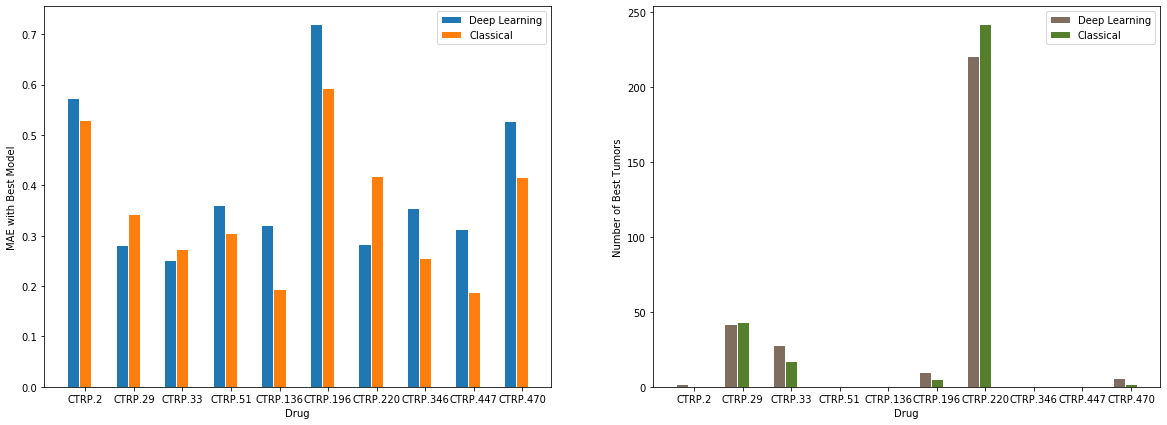

In [0]:
barWidth = 0.25
r1 = np.arange(len(dl_maes))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.bar(r1, dl_maes, width=barWidth, edgecolor='white', label='Deep Learning')
plt.bar(r2, classic_maes, width=barWidth, edgecolor='white', label='Classical')

plt.xlabel('Drug')
plt.ylabel('MAE with Best Model')
plt.xticks([r + barWidth for r in range(len(dl_maes))], drug_names)
plt.legend()

num_best_tumors = []

for n in drug_names:
  num_best_tumors.append(len(best_tumors[n]))


plt.subplot(1,2,2)
plt.bar(r1, num_best_tumors, color='#7f6d5f', width=barWidth, edgecolor='white', label='Deep Learning')
plt.bar(r2, classic_num_best_tumors, color='#557f2d', width=barWidth, edgecolor='white', label='Classical')

plt.xlabel('Drug')
plt.ylabel('Number of Best Tumors')
plt.xticks([r + barWidth for r in range(len(dl_maes))], drug_names)
plt.legend()
plt.show()


Above we can see the MAE for both the best classical method and the deep learning method as well as the number of tumors each drug was best for in both cases. Interestly, the deep learning model had a lower MAE for only 3 of the 10 drugs. The classical method performed better for 7 of the 10 methods. The differences were minimal (< 0.1), but this definitely has serious implications. 

To me, this shows how difficult it is to create an accurate deep learning model for regression testing. I tried a variety of different networks and had trouble finding one that could consistently perform better than the classical model. This also speaks to the power of classical regression models.

The 2nd graph shows how the results in both cases were extremely similar as the best drugs for each tumor were fairly similar. However, they were not the same for all drugs, which is significant as the cost of using the wrong drug could be dramatic.

## Part 2. Dose independent formulation (50 points).

#### Loading and Proprocessing Data

I load the data for part 2. I then drop all columns that have all values equal to 'na'. Next, I set all other 'na' values to the mean of the column.

In [0]:
#Load the data
drug_df = pd.read_csv(
    "/content/drive/My Drive/MLiM-Datasets/HW3/data_frames/Part2/df_top21_bal_AUC.tsv",
    dtype=float,
    na_values=['na'],
    delimiter='\t')

#Calculate the indicator variable.
auc = drug_df.pop("AUC").tolist()
y = np.array([1 if a <= 0.5 else 0 for a in auc])

In [0]:
#Drop all columns where all values are na
drug_df = drug_df.dropna(axis='columns', how='all')

#Replace all nan values with column mean.
n =len(drug_df.columns)
fixed_columns = []
for i,(col_name,hasNan) in enumerate(zip(drug_df.columns, (drug_df.isnull().sum()>0).tolist())):
  col = drug_df[col_name]
  if hasNan:
    m = np.nanmean(col)
    fixed_columns.append([m if math.isnan(v) else v for v in col])
  else:
    fixed_columns.append(col)

drug_df = pd.DataFrame(np.array(fixed_columns).T, columns = drug_df.columns)
      

In [0]:
#Normalize the data
def normalize_large_data(df):
  scaler = preprocessing.StandardScaler()
  columns = df.columns
  scaled_df = scaler.fit_transform(df)
  df = pd.DataFrame(scaled_df, columns=columns)
  return df

drug_df = normalize_large_data(drug_df)

#### Helper Functions

In [0]:
#Run cross validation with 5-folds and returns the confusion matrix.

def five_fold_predict_stats_classification(model, X, Y, c=2):
  cm = np.zeros((c,c), dtype=int)
  f1s = []
  accs = []
  tim = []
  unique_labels = np.unique(Y)
  kf = KFold(n_splits=5)
  #Run 5 times with each fold
  for train_index, test_index in kf.split(X):
      X_train, X_test = X.values[train_index], X.values[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
      with Timer(tim):
        model.fit(X_train, y_train)
      y_hat = model.predict(X_test)
      cm +=confusion_matrix(y_test, y_hat, labels=unique_labels)
      f1s.append(f1_score(y_test, y_hat, average='micro'))
      accs.append(np.mean(y_hat != y_test))
  
  #Return the aggregate of the scores for all folds
  tp, fp, tn, fn = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2*(recall*precision)/(recall+precision)
            
  return (cm, f1, np.mean(accs),np.mean(tim))

#Print statement for printing the results from the five fold confusion matrix function

def print_five_fold_results(dataset_name, model_name, results):
  print("----------------------------------------------------")
  print("Results for running", model_name, "with the", dataset_name,"Dataset")
  print("The confusion matrix is:")
  print(results[0])
  print("The f1 score is:", results[1])
  print("The percent error is:", results[2])
  print("The average runtime for training is:", results[3], "seconds")
  print("----------------------------------------------------")
  print("")
  
  

### a) Using SciKit Learn build a machine learning classifier that predicts drug response using the aggregated `df_top21_bal.tsv` dataset. Use AUC1 as the label. Threshold AUC1 ($> 0.50 = 0$, $\leq 0.50 = 1$) for the prediction target to make it a classification problem. Input data includes tumor features and drug features.


I decided to use the classifiers Guassian Naive Bayes, SGD, KNeighbors, Deicision Tree, Random Forest and Ada Boost. I run each model using 5-fold through the helper function defined just above. I then print all of the results.

In [0]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

#Run the predict function on both data sets and print

#Define names of classifiers
names = [
 "Gaussian Naive Bayes",
 "SGD",
 "Nearest Neighbors", 
 "Decision Tree", 
 "Random Forest",
 "Ada Boost"
]

#Define classifiers
classifiers = [
    GaussianNB(),
    SGDClassifier(random_state=0),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0, n_estimators = 25),
    AdaBoostClassifier(n_estimators=50, random_state=0)
]


classifier_results = []
all_results = []
num_models = len(classifiers)
print('\r', "Models Completed:", 0, "out of",num_models, end='')
for i, name, clf in list(zip(range(len(names)),names, classifiers)):
  #Append the results from the estimations
  all_results.append(five_fold_predict_stats_classification(clf, drug_df, y))
  print('\r', "Models Completed:", i+1, "out of",num_models, end='')
  

 Models Completed: 6 out of 6

In [0]:
for n,results in zip(names,all_results):
  print_five_fold_results("Protein Coding Genes", n, results)

----------------------------------------------------
Results for running Gaussian Naive Bayes with the Protein Coding Genes Dataset
The confusion matrix is:
[[ 990 3335]
 [  52 3777]]
The f1 score is: 0.21777386713594368
The percent error is: 0.41537962708714976
The average runtime for training is: 0.5030639171600342 seconds
----------------------------------------------------

----------------------------------------------------
Results for running SGD with the Protein Coding Genes Dataset
The confusion matrix is:
[[3536  789]
 [ 696 3133]]
The f1 score is: 0.6432599599781699
The percent error is: 0.18211914102906493
The average runtime for training is: 6.005705213546753 seconds
----------------------------------------------------

----------------------------------------------------
Results for running Nearest Neighbors with the Protein Coding Genes Dataset
The confusion matrix is:
[[3363  962]
 [ 582 3247]]
The f1 score is: 0.6150891632373113
The percent error is: 0.1893544928964503

The random forest performed the best with 13.5% error. This is not too surprising given how well it performed on the last homework. The Ada Boost was the next best, but took over a minute per training, which is far more than any of the other models. SGD, Decision Tree and Nearest Neighbors all perforect about the same. The Nearest Neighbors had the fastest runtime, but it took a while to predict the values, which is definitely a large downside. I was glad to see that SGD did perform decently well here, given how terrible it was for regression in part 1. Similarly to part 1, the Gaussian Naive Bayes was definitely the far worst with an error rate of over 40%. However, the Gaussian NB had only 52 false negatives, which is extremely wierd given that no model had less than 500. The Gaussian also performed the fastest by far, which I think speaks to why the model was not that gream.

Overall, it is evident that the Random Forest performed the best and had a low average runtime to back it up.

### b) Using ​Keras​, build a deep learning classifier that performs the same classification task as in part a.

In [0]:
#A Helper function that runs 5 fold on the model and returns the error on a seperate testing set
def five_fold_nn_samples(model, X, y, eps):
  cm = [[0,0],[0,0]]
  accs = []
  f1s = []
  ns = 5
  tim = []
  kf = KFold(n_splits=ns)
  unique_labels = np.unique(y)
  model.save_weights('empty')
  for train_index, test_index in kf.split(X):
      X_train, X_test = X.values[train_index], X.values[test_index]
      y_train, y_test = utils.to_categorical(y)[train_index], y[test_index]
      with Timer(tim):
        hist = model.fit(x=X_train, y=y_train, epochs=eps, batch_size=64, shuffle=True, verbose = 0)
      y_hat = [int(ys[1]) for ys in np.rint(model.predict(X_test))]
      cm +=confusion_matrix(y_test, y_hat, labels=unique_labels)
      f1s.append(f1_score(y_test, y_hat, average='micro'))
      accs.append(np.mean(y_hat != y_test))
      
  #Return the aggregate of the scores for all folds
  tp, fp, tn, fn = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2*(recall*precision)/(recall+precision)
            
  return (cm, f1, np.mean(accs),np.mean(tim))

I use a fully connected model with 6 layers. Each layer gets incrementally smaller until we arrive a final layer with 2 classes. After the 2nd layer and the 4th layer, I dropout 0.1.

In [0]:
#A fully connected model for classification
def classification_model_fc(i,c):
  model = models.Sequential()
  model.add(layers.InputLayer(i,))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(c, activation='softmax'))
  model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=['accuracy'])
  return model

In [0]:
results = five_fold_nn_samples(classification_model_fc(len(drug_df.columns), 2), drug_df, y, 10)

In [0]:
print_five_fold_results("df_top21_bal.tsv", "Fully Connected Neural Network", results)

----------------------------------------------------
Results for running Fully Connected Neural Network with the df_top21_bal.tsv Dataset
The confusion matrix is:
[[3844  481]
 [ 366 3463]]
The f1 score is: 0.6609353507565336
The percent error is: 0.10387251601448921
The average runtime for training is: 9.213688516616822 seconds
----------------------------------------------------



The training error is 10.3%. This is better by 3% than any model we used in the classical approach. This is not surprising given that deep learning should perform better. I chose to structure my network as one that shrinks with each layer to slowly reduce the size of the inputs. I felt that this worked well and got a good error rate. I tried several variations, but had luck with none of them.

## Write Up

Part 1 of this lab was the first time that I used regressors this quarter. It was really insightful to finally get to use them in our homework.

In (a), I experimented with different classical regressors. I experimented with SGD, SBR, Gaussian Process, Bayesian Ridge and Decision Tree. First off, the SGD regressor was terrible. This was a little bit shocking to me given that it is a fairly strong classifier and very reliant in deep learning networks. The rest were all fairly similar, which wasn’t too shocking given how the data is fairly complete and not overly complex. The Bayesian Ridge performed the best for all drugs and took the longest. This surprised me as I tried to use it on the previous homework for classification and it performed terribly. It is evident that this model is amazing in some circumstances and terrible in others. Also, in (a), there was a lot of management of data. Dealing with 10 different data frames, finding common tumors and comparing the results was a lot of data processing. Data processing is something that is extremely integral in machine learning but does not normally seem to get enough attention. The results were interesting as one drug performed the best for most of the tumors while some performed best for none of them. 

In (b), I looked at the effects of feature reduction. I reduced all of the drugs to less than 100 features and ran the Bayesian Ridge regression with reduced features. The results showed that feature reduction led to dramatically reduced runtimes, which was expected given that there was only a fraction of the original columns. The MAE was only slightly higher or the same with the reduced features. Higher MAE is expected, but the fact that it was only slightly higher is really interesting. This could be because only the presence of a few genes relate to a drug’s effectiveness, so a lot of drugs are not necessary in determining how good a drug will work. This really highlights the importance of feature reduction and it is certainly something I look forward to working with more as the quarter progresses. There was little overlap between the best features. I expected there to be like 20 features in common between all of the drugs, but there were 0. Within 2 individual drugs there was no more than 16. This shows that different drugs depend on different things to be effective, which sheds light to the difficulty of prescribing drugs to patients. Without advanced data analysis, it is really hard to determine which drugs are right for which patient as so many different things go into determining this.

In (c), I experimented with using deep learning for regression. I was surprised at how hard it was to make a network that performed better than the Bayesian Ridge. I experimented a lot with different amounts of layers, features, dropouts, optimizers and activations, but could not create a model that consistently outperformed the Bayesian Ridge. This demonstrated that the difficulty of deep learning is not in getting a model to work, but it is in building and constructing a model.

In part 2, I worked with an aggregate dataset to determine a drug’s effectiveness. In this case, we used a classifier instead of a regressor.

In (a), I chose to use Gaussian Naive Bayes, SGD, Nearest Neighbors, Decision Tree and Random Forest. The Random Forest performed the best with 13.5% error. The Gaussian Naive Bayes performed the worst with 41.5% error. These results were not surprising as Random Forest performed best on the last homework and Gaussian was also terrible on the previous homework. SGD performed decently with about 18.2% percent, which is significant given how bad it did as a regressor. The more we work with different classical machine learning models, the more I learn about the benefits and pitfalls of each of them.

In (b), I built a neural network to classify the drugs. Unlike in part 1c, I was able to create a network that outperformed the classical machine learning models fairly easily with an error rate of 10.3%. It is interesting to see how much more difficult it was to create a regression model than a classification one. Designing neural networks is certainly something that requires skill and I look forward to working with them more and continue to develop my skills in building deep learning networks.
